In [ ]:
!pip install librosa

In [13]:
import numpy as np
import theano
theano.config.floatX='float32'
import theano.tensor as T
import lasagne
from lasagne.layers import *
import pickle
from tqdm import tqdm_notebook
from librosa import load, logamplitude
from librosa.feature import melspectrogram
from multiprocessing import Pool
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.style.use('classic')
import os

# Let's start!


## Get data

Get spectrogram, divide by 77 - euristic number of samples nns were trained on.

In [136]:
def get_spectrogram(path):
    """Строим спектограмму из wav файла"""
    # Librosa seems to work only with files with sampling frequency >= 44,1 кГц
    y, sr = load(path)
    S = melspectrogram(y, sr=sr, n_mels=128)
    log_S = logamplitude(S, ref_power=np.max)
    return log_S

file_name = os.listdir("./test")
spectrogram = get_spectrogram("./test/" + file_name[0])

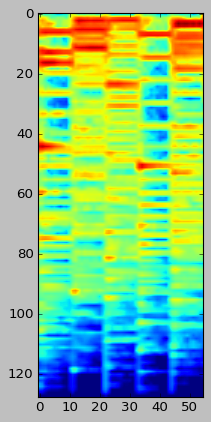

In [137]:
random_num = len(spectrogram)
plt.imshow(spectrogram[:, :random_num])

In [138]:
len_0 = 128
len_1 = 77
if len(spectrogram[0])/len_1 > len(spectrogram[0])//len_1:
    len_2 = len(spectrogram[0])//len_1 + 1
else:
    len_2 = len(spectrogram[0])//len_1

targets = np.array([[[-80. for i in range(len_1)] for j in range(len_0)] for k in range(len_2)], dtype='float32')

for k in range(len_2 - 1):
    for i in range(len_0):
        for j in range(len_1):
            targets[k][i][j] = spectrogram[i][j + k*len_1]
for i in range(len_0):
    for j in range(len_1 + len_1*(len_2 - 2), len(spectrogram[0])):
        targets[len_2-1][i][j - (len_1 + len_1*(len_2 - 2))] = spectrogram[i][j] 

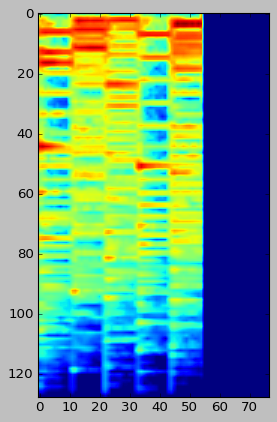

In [139]:
plt.imshow(targets[0])

## So the idea is...

There are 5 CNNs for notes recognition, there are 88 notes on piano keyboard to recognize. Empiricaly split piano keyboard on 4 sections, train one CNN for each section and one for the whole range.

In [140]:
X = targets/80.
input_X, target_y = T.tensor3("X", dtype='float32'), T.tensor3("y", dtype='int32')

up_nn = lasagne.layers.InputLayer(shape=(None, X.shape[1], X.shape[2]), input_var=input_X/80.) 
up_nn = lasagne.layers.Conv1DLayer(up_nn, 50, 6) #That number of filters works better for this nn
up_nn = lasagne.layers.MaxPool1DLayer(up_nn, 3)
up_nn = lasagne.layers.Conv1DLayer(up_nn, 50, 4) 
up_nn = lasagne.layers.Conv1DLayer(up_nn, 88, 1,nonlinearity=T.nnet.sigmoid)


mup_nn = lasagne.layers.InputLayer(shape=(None, X.shape[1], X.shape[2]), input_var=input_X/80.)
mup_nn = lasagne.layers.Conv1DLayer(mup_nn, 64, 6)
mup_nn = lasagne.layers.MaxPool1DLayer(mup_nn, 3)
mup_nn = lasagne.layers.Conv1DLayer(mup_nn, 64, 4) 
mup_nn = lasagne.layers.Conv1DLayer(mup_nn, 88, 1,nonlinearity=T.nnet.sigmoid)


mdown_nn = lasagne.layers.InputLayer(shape=(None, X.shape[1], X.shape[2]), input_var=input_X/80.)
mdown_nn = lasagne.layers.Conv1DLayer(mdown_nn, 64, 6)
mdown_nn = lasagne.layers.MaxPool1DLayer(mdown_nn, 3)
mdown_nn = lasagne.layers.Conv1DLayer(mdown_nn, 64, 4) 
mdown_nn = lasagne.layers.Conv1DLayer(mdown_nn, 88, 1,nonlinearity=T.nnet.sigmoid)


down_nn = lasagne.layers.InputLayer(shape=(None, X.shape[1], X.shape[2]), input_var=input_X/80.) 
down_nn = lasagne.layers.Conv1DLayer(down_nn, 64, 6)
down_nn = lasagne.layers.MaxPool1DLayer(down_nn, 3)
down_nn = lasagne.layers.Conv1DLayer(down_nn, 64, 4) 
down_nn = lasagne.layers.Conv1DLayer(down_nn, 88, 1,nonlinearity=T.nnet.sigmoid)

aa_nn = lasagne.layers.InputLayer(shape=(None, X.shape[1], X.shape[2]), input_var=input_X/80.) 
aa_nn = lasagne.layers.Conv1DLayer(aa_nn, 64, 6)
aa_nn = lasagne.layers.MaxPool1DLayer(aa_nn, 3)
aa_nn = lasagne.layers.Conv1DLayer(aa_nn, 64, 4)
aa_nn = lasagne.layers.Conv1DLayer(aa_nn, 88, 1,nonlinearity=T.nnet.sigmoid)

In [141]:
lasagne.layers.set_all_param_values(up_nn, pickle.load(open('up_nn', 'rb')))
lasagne.layers.set_all_param_values(mup_nn, pickle.load(open('mup_nn', 'rb')))
lasagne.layers.set_all_param_values(mdown_nn, pickle.load(open('mdown_nn', 'rb')))
lasagne.layers.set_all_param_values(down_nn, pickle.load(open('down_nn', 'rb')))
lasagne.layers.set_all_param_values(aa_nn, pickle.load(open('third_nn', 'rb')))

In [142]:
up_pred = lasagne.layers.get_output(up_nn)
mup_pred = lasagne.layers.get_output(mup_nn)
mdown_pred = lasagne.layers.get_output(mdown_nn)
down_pred = lasagne.layers.get_output(down_nn)
aa_pred = lasagne.layers.get_output(aa_nn)

up_predict_probas = theano.function([input_X], up_pred)
mup_predict_probas = theano.function([input_X], mup_pred)
mdown_predict_probas = theano.function([input_X], mdown_pred)
down_predict_probas = theano.function([input_X], down_pred)
aa_predict_probas = theano.function([input_X], aa_pred)

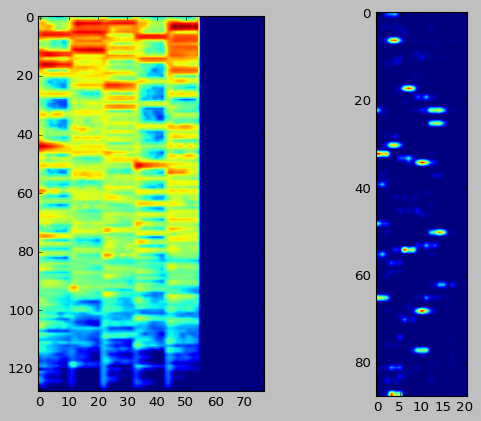

In [143]:
plt.subplot(1, 2, 1)
b = 0
plt.imshow(targets[b])
plt.subplot(1, 2, 2)
all_nns = aa_predict_probas(X[b:b+1])[0]+up_predict_probas(X[b:b+1])[0]+mup_predict_probas(X[b:b+1])[0]+mdown_predict_probas(X[b:b+1])[0]+down_predict_probas(X[b:b+1])[0]
plt.imshow(all_nns)

In [163]:
a = [[i+21 for i in range(88) if all_nns[i][j] > 0.8] for j in range(21)]

In [ ]:
53,69,86
53,69,86
53,69,86
27,51,108
27,51,108
27,51,108
38,75
38,75
38,75
55,89,98
55,89,98
55,89,98
43,46,71
43,46,71
43,46,71

In [170]:
predictions

[[53, 69, 86],
 [53, 86],
 [53, 86],
 [27, 51, 108],
 [27, 51, 108],
 [108],
 [38, 75],
 [38, 75],
 [38, 75],
 [55, 89, 98],
 [55, 89, 98],
 [55, 89, 98],
 [43, 46],
 [43, 46, 71],
 [43, 46, 71],
 [71],
 [],
 [],
 [],
 [],
 []]

In [119]:
notes = []
for i in range(X.shape[0]):
    all_nns = aa_predict_probas(X[b:b+1])[0]+up_predict_probas(X[b:b+1])[0]+mup_predict_probas(X[b:b+1])[0]+mdown_predict_probas(X[b:b+1])[0]+down_predict_probas(X[b:b+1])[0]
    notes.append(all_nns)

In [120]:
a

[[],
 [],
 [82],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]